# Sélection du meilleur seuil

In [1]:
import time

t_debut = time.time()

import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score

from tools import datasets, convert_keys_to_int, PDF, Modelisation

pdf = PDF('output/selection_seuil/')

Importation de la liste des variables explicatives sélectionnées et des meilleurs paramètres pour chaque modèle.

In [2]:
best_LR = "LR_RFECV"
best_RF = "Forest_RFECV"
best_XGB = "XGBoost_RFECV"

In [3]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)[best_LR]
    LR_PARAMS = convert_keys_to_int(LR_PARAMS)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêts aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    RF_COLUMNS = json.load(column_file)
    RF_COLUMNS_QUANT = RF_COLUMNS['columns_quant']
    RF_COLUMNS_CAT = RF_COLUMNS['columns_cat']
    RF_COLUMNS = RF_COLUMNS_QUANT + RF_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    RF_PARAMS = json.load(param_file)[best_RF]
    RF_PARAMS = convert_keys_to_int(RF_PARAMS)

print(f'Variables explicatives forêts aléatoires ({len(RF_COLUMNS)}) :')
display(RF_COLUMNS)

print(f'Meilleurs paramètres forêts aléatoires ({len(RF_PARAMS)}) :')
RF_PARAMS['class_weight'] = {int(k): v for k,v in RF_PARAMS['class_weight'].items()}
display(RF_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XGB_COLUMNS = json.load(column_file)
    XGB_COLUMNS_QUANT = XGB_COLUMNS['columns_quant']
    XGB_COLUMNS_CAT = XGB_COLUMNS['columns_cat']
    XGB_COLUMNS = XGB_COLUMNS_QUANT + XGB_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XGB_PARAMS = json.load(param_file)[best_XGB]
    XGB_PARAMS = convert_keys_to_int(XGB_PARAMS)

print(f'Variables explicatives XGBoost ({len(XGB_COLUMNS)}) :')
display(XGB_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XGB_PARAMS)}) :')
display(XGB_PARAMS)

Variables explicatives régression logistique (11) :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']

Meilleurs paramètres régression logistique (2) :


{'C': 0.007278953843983146, 'class_weight': {0: 1, 1: 20}}

Variables explicatives forêts aléatoires (9) :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêts aléatoires (8) :


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': False,
 'n_jobs': -1}

Variables explicatives XGBoost (9) :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']

Meilleurs paramètres XGBoost (11) :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'n_jobs': -1}

## 1. Régression logistique

In [4]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
X = datasets_df['X_only_quant_scaled']
y = datasets_df['y']
X_train_LR, X_val_LR, y_train_LR, y_val_LR = train_test_split(X, y, train_size=0.80, random_state=1234)

In [5]:
%%time
clf = LogisticRegression(**LR_PARAMS)
clf.fit(X_train_LR, y_train_LR)

y_probas_LR = clf.predict_proba(X_val_LR)[:, 1]

CPU times: user 24.3 s, sys: 1min 6s, total: 1min 30s
Wall time: 2.1 s


In [6]:
def f3_LR(seuil):
    y_pred = (y_probas_LR >= seuil) * 1
    precision = precision_score(y_val_LR, y_pred)
    recall = recall_score(y_val_LR, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_LR_v = np.vectorize(f3_LR)

In [7]:
[s_opt_LR] = scipy.optimize.fmin(lambda s: - f3_LR(s), 0.5)
print(f"Meilleur seuil : {s_opt_LR}")
print(f"Score F3 : {f3_LR(s_opt_LR)}")

Optimization terminated successfully.
         Current function value: -0.481984
         Iterations: 9
         Function evaluations: 19
Meilleur seuil : 0.5005859374999999
Score F3 : 0.48198367324820296


In [8]:
def graph_seuil(S, Y, opt):
    fig, ax = plt.subplots()
    plt.plot(S, Y)
    plt.axvline(x=0.5, color='black', linewidth=0.5, label="Seuil 0.5")
    plt.axvline(x=opt, color='red', linewidth=0.5, label="Seuil optimal")

    ax.set_xlim(0, 1)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='major')
    ax.grid(b=True, which='minor', axis='x', linestyle='--', alpha=0.3)
    ax.grid(b=True, which='minor', axis='y', linestyle='--', alpha=0.3)

    ax.set_xlabel("Seuil")
    ax.set_ylabel("Score F3") 

    plt.legend()
    pdf.export()
    plt.show()

Export PDF : output/selection_seuil/00.pdf



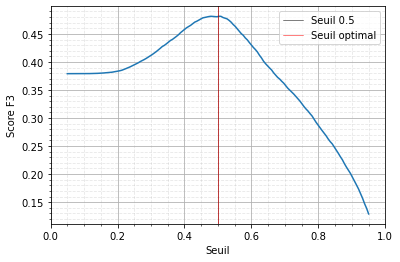

CPU times: user 27.7 s, sys: 190 ms, total: 27.8 s
Wall time: 27.6 s


In [9]:
%%time
S = np.linspace(0.05, 0.95, 150)
graph_seuil(S, f3_LR_v(S), s_opt_LR)

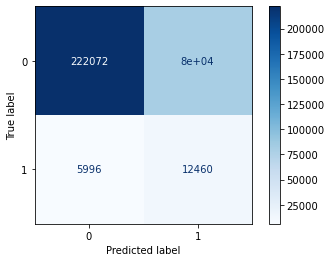

f1 : 0.2243
f3 : 0.4816
f5 : 0.5847
recall : 0.6751
negative predictive value : 0.9737
precision : 0.1345
roc_auc : 0.7720
training time : 2.134s
prediction time : 0.009s


In [10]:
m = Modelisation(X, y, LogisticRegression(**LR_PARAMS))
m.show_conf_matrix()
m.show_metrics_score()
f3 = m.metrics_score['f3']

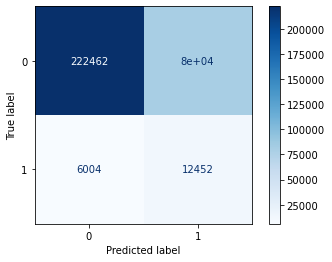

f1 : 0.2250
f3 : 0.4820
f5 : 0.5848
recall : 0.6747
negative predictive value : 0.9737
precision : 0.1350
roc_auc : 0.7720
training time : 2.08s
prediction time : 0.022s


In [11]:
m = Modelisation(X, y, LogisticRegression(**LR_PARAMS), seuil=s_opt_LR)
m.show_conf_matrix()
m.show_metrics_score()
f3_ajuste = m.metrics_score['f3']

In [12]:
SCORES = []
metrics = {}
metrics['model_name'] = "Régression logistique"
metrics['f3'] = f3
metrics['f3_ajusté'] = f3_ajuste
SCORES.append(metrics)

## 2. Random Forest

In [13]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=RF_COLUMNS_QUANT, columns_cat=RF_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']
X_train_RF, X_val_RF, y_train_RF, y_val_RF = train_test_split(X, y, train_size=0.80, random_state=1234)

In [14]:
%%time
clf = RandomForestClassifier(**RF_PARAMS)
clf.fit(X_train_RF, y_train_RF)

y_probas_RF = clf.predict_proba(X_val_RF)[:, 1]

CPU times: user 1h 6min 19s, sys: 15.4 s, total: 1h 6min 35s
Wall time: 1min 23s


In [15]:
def f3_RF(seuil):
    y_pred = (y_probas_RF >= seuil) * 1
    precision = precision_score(y_val_RF, y_pred)
    recall = recall_score(y_val_RF, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_RF_v = np.vectorize(f3_RF)

In [16]:
[s_opt_RF] = scipy.optimize.fmin(lambda s: - f3_RF(s), 0.5)
print(f"Meilleur seuil : {s_opt_RF}")
print(f"Score F3 : {f3_RF(s_opt_RF)}")

Optimization terminated successfully.
         Current function value: -0.535563
         Iterations: 12
         Function evaluations: 26
Meilleur seuil : 0.6492187500000004
Score F3 : 0.5355626412010704


Export PDF : output/selection_seuil/01.pdf



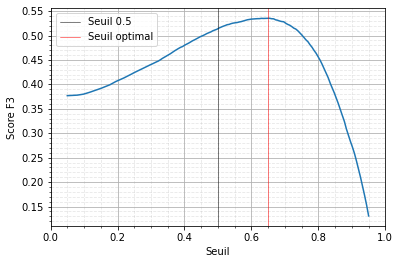

CPU times: user 27.3 s, sys: 409 ms, total: 27.7 s
Wall time: 27.5 s


In [17]:
%%time
S = np.linspace(0.05, 0.95, 150)
graph_seuil(S, f3_RF_v(S), s_opt_RF)

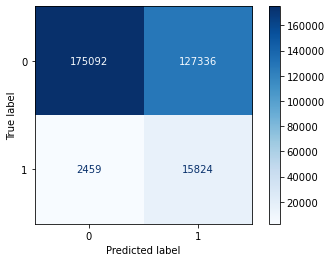

f1 : 0.1960
f3 : 0.5143
f5 : 0.6854
recall : 0.8655
negative predictive value : 0.9862
precision : 0.1105
roc_auc : 0.8259
training time : 1min, 18.244s
prediction time : 0.991s


In [18]:
m = Modelisation(X, y, RandomForestClassifier(**RF_PARAMS))
m.show_conf_matrix()
m.show_metrics_score()
f3 = m.metrics_score['f3']

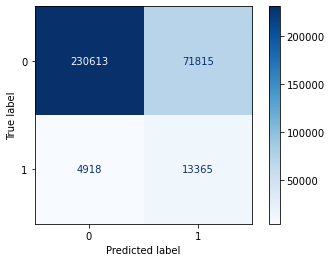

f1 : 0.2584
f3 : 0.5352
f5 : 0.6408
recall : 0.7310
negative predictive value : 0.9791
precision : 0.1569
roc_auc : 0.8259
training time : 1min, 16.593s
prediction time : 0.837s


In [19]:
m = Modelisation(X, y, RandomForestClassifier(**RF_PARAMS), seuil=s_opt_RF)
m.show_conf_matrix()
m.show_metrics_score()
f3_ajuste = m.metrics_score['f3']

In [20]:
metrics = {}
metrics['model_name'] = "Random Forest"
metrics['f3'] = f3
metrics['f3_ajusté'] = f3_ajuste
SCORES.append(metrics)

## 3. XGBoost

In [21]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=XGB_COLUMNS_QUANT, columns_cat=XGB_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']
X_train_XGB, X_val_XGB, y_train_XGB, y_val_XGB = train_test_split(X, y, train_size=0.80, random_state=1234)

In [22]:
%%time
clf = XGBClassifier(**XGB_PARAMS)
clf.fit(X_train_XGB, y_train_XGB)

y_probas_XGB = clf.predict_proba(X_val_XGB)[:, 1]

CPU times: user 5min 44s, sys: 898 ms, total: 5min 45s
Wall time: 12 s


In [23]:
def f3_XGB(seuil):
    y_pred = (y_probas_XGB >= seuil) * 1
    precision = precision_score(y_val_XGB, y_pred)
    recall = recall_score(y_val_XGB, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_XGB_v = np.vectorize(f3_XGB)

In [24]:
[s_opt_XGB] = scipy.optimize.fmin(lambda s: - f3_XGB(s), 0.5)
print(f"Meilleur seuil : {s_opt_XGB}")
print(f"Score F3 : {f3_XGB(s_opt_XGB)}")

Optimization terminated successfully.
         Current function value: -0.536410
         Iterations: 10
         Function evaluations: 21
Meilleur seuil : 0.4799804687499999
Score F3 : 0.5364095961816241


Export PDF : output/selection_seuil/02.pdf



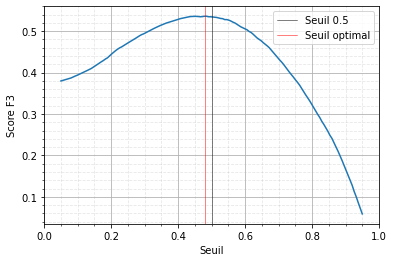

CPU times: user 27.5 s, sys: 267 ms, total: 27.8 s
Wall time: 27.5 s


In [25]:
%%time
S = np.linspace(0.05, 0.95, 150)
graph_seuil(S, f3_XGB_v(S), s_opt_XGB)

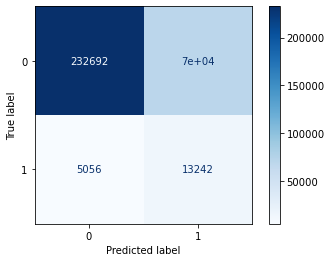

f1 : 0.2615
f3 : 0.5347
f5 : 0.6371
recall : 0.7237
negative predictive value : 0.9787
precision : 0.1596
roc_auc : 0.8258
training time : 12.69s
prediction time : 0.105s


In [26]:
m = Modelisation(X, y, XGBClassifier(**XGB_PARAMS))
m.show_conf_matrix()
m.show_metrics_score()
f3 = m.metrics_score['f3']

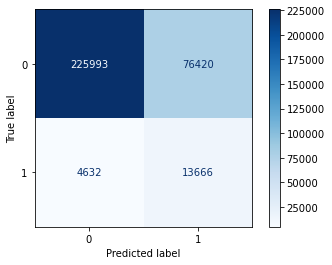

f1 : 0.2522
f3 : 0.5364
f5 : 0.6489
recall : 0.7469
negative predictive value : 0.9799
precision : 0.1517
roc_auc : 0.8258
training time : 11.309s
prediction time : 0.096s


In [27]:
m = Modelisation(X, y, XGBClassifier(**XGB_PARAMS), seuil=s_opt_XGB)
m.show_conf_matrix()
m.show_metrics_score()
f3_ajuste = m.metrics_score['f3']

In [28]:
metrics = {}
metrics['model_name'] = "XGBoost"
metrics['f3'] = f3
metrics['f3_ajusté'] = f3_ajuste
SCORES.append(metrics)

## 4. Comparaison

Export PDF : output/selection_seuil/03.pdf



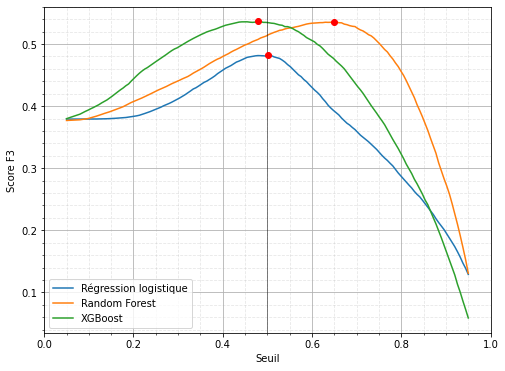

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(S, f3_LR_v(S), label="Régression logistique")
plt.plot(S, f3_RF_v(S), label="Random Forest")
plt.plot(S, f3_XGB_v(S), label="XGBoost")
plt.axvline(x=0.5, color='black', linewidth=0.5)

plt.plot(s_opt_LR, f3_LR_v(s_opt_LR), marker='o', color="red")
plt.plot(s_opt_RF, f3_RF_v(s_opt_RF), marker='o', color="red")
plt.plot(s_opt_XGB, f3_XGB_v(s_opt_XGB), marker='o', color="red")

ax.set_xlim(0, 1)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major')
ax.grid(b=True, which='minor', axis='x', linestyle='--', alpha=0.3)
ax.grid(b=True, which='minor', axis='y', linestyle='--', alpha=0.3)


ax.set_xlabel("Seuil")
ax.set_ylabel("Score F3") 

plt.legend()
pdf.export()
plt.show()

In [30]:
scores_df = pd.DataFrame(SCORES).set_index('model_name')
scores_df.sort_values(by='f3', ascending=False).to_csv('backups/SCORES_seuil.csv')
scores_df.sort_values(by='f3', ascending=False).style.background_gradient(cmap='Blues')

,f3,f3_ajusté
model_name,,
XGBoost,0.534717,0.536410
Random Forest,0.514255,0.535184
Régression logistique,0.481551,0.481984


**Sauvegarde des résultats**

In [31]:
with open('backups/THRESHOLD.json', 'w') as outfile:
    json.dump({'LR': s_opt_LR, 'Forest': s_opt_RF, 'XGBoost': s_opt_XGB}, outfile)

In [32]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t_debut))}")

Durée totale d'exécution : 00:08:58
